In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print('Changed directory to', os.getcwd())

Changed directory to /morphoml


# Load data

In [3]:
from morphoml.dataprep import load_hdf5, load_folder

npix = 128
transfer_learn = False  # Start from pretrained (imagenet) CNN?
from_folder = True  # folder of images? Else use hdf5 file.
if from_folder:
    imgs, names = load_folder(f'./data/images/autoscale/{npix}pix/')
else:
    imgs, names = load_hdf5(f'./data/images/processed_scauto_{npix}.h5')

print('Images shape:', imgs.shape, '; Names shape:', names.shape)
names[:5]

Images shape: (73627, 128, 128) ; Names shape: (73627,)


array([1237678617934364898, 1237668624625631332, 1237658425159843981,
       1237664668971499685, 1237665126930120850])

In [4]:
df_meta = pd.read_csv('./data/metadata/metadata.tsv',
                      sep='\t', index_col=0)
print(df_meta.shape)
df_meta.head()

(73627, 30)


,RA,DEC,D25,redshift,GalSize_kpc,D_Mpc,d_pix_kpc,reduced_chi_square,logM_bayes,logM_bayes_err,...,ML_zibetti,RA_leda,DEC_leda,D25_leda,R25_leda,pa_leda,id_gz1,dist_gz1,id_gz2,dist_gz2
SDSS_ID,,,,,,,,,,,,,,,,,,,,,
1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,3.980811,10.328326,0.057643,...,2.553861,231.318646,41.346012,0.516416,4.677351,52.77,552094,0.000016,131054,0.191547
1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.537818,9.834362,0.037180,...,1.054716,236.009916,39.288303,0.441570,2.897344,131.08,572069,0.000104,177157,0.094953
1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.280960,9.851568,0.057156,...,0.805557,237.494992,9.278609,0.629506,1.312200,155.89,577778,0.000041,37238,0.000052
1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.192938,10.439780,0.044860,...,1.775870,242.008785,36.053987,0.557186,1.315225,63.55,596382,0.000021,76320,0.000036
1237662474235085097,251.31645,25.60003,0.512861,0.0681,43.540800,291.857134,0.565985,1.540025,9.999021,0.040437,...,1.205651,251.316496,25.600029,0.510505,3.539973,42.81,624773,0.000070,62784,0.079806


In [ ]:
n_train = 30000
datasets = ['train', 'val', 'test']
d_data = {ds: {} for ds in datasets}

def create_x(idx):
    return np.expand_dims(np.array(imgs)[idx, ...].copy(), axis=-1)

def create_y(labels):
    return df_meta.loc[labels, 'M/L'].copy().values

def create_xaug(labels):
    return df_meta.loc[labels, ['distance_Mpc', 'L_g']].copy().values

for ds in datasets:
    labels = np.loadtxt(f'./data/split/{ds}_labels.txt', dtype=np.int)
    if ds == 'train':
        labels = labels[:n_train]
    idx = np.array([np.where(names[:] == labels[i])[0][0] for i in range(len(labels))])
    d_data[ds]['labels'] = labels
    d_data[ds]['idx'] = idx
    d_data[ds]['x'] = create_x(idx)
    d_data[ds]['ylin'] = create_y(labels)
    d_data[ds]['x_aug'] = create_xaug(labels)
    print(f'{ds} size: {len(labels)}')
    
x_aug_mean, x_aug_std = np.mean(d_data['train']['x_aug']), np.std(d_data['train']['x_aug'])
d_data['train']['x_aug_mean'], d_data['train']['x_aug_std'] = x_aug_mean, x_aug_std
for ds in datasets:
    d_data[ds]['x_aug_norm'] = (d_data[ds]['x_aug'] - x_aug_mean) / x_aug_std
    
print(d_data['test']['labels'][:5])
print(d_data['test']['idx'][:5])
print(d_data['test']['x'].shape)
print(d_data['train']['ylin'].shape)
print(d_data['val']['x_aug'].shape)

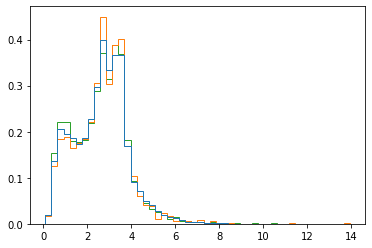

In [6]:
plt.hist([d_data[ds]['ylin'] for ds in datasets], 50, 
         histtype='step', density=True);

# Dataframe for recording model performance

In [7]:
columns = ['npix', 'ntrain', 'nlayer', 'activation', 'batch_size', 'dropout', 'batchnorm',
           'optimizer', 'logspace', 'add_inputs', 'architecture']
metrics = ['RMSLE', 'logR2', 'RMSE', 'R2']

for dataset in datasets:
    for metric in metrics:
        columns.append(f'{dataset}_{metric}')

if not 'df_results' in globals():
    print('Initialized results dataframe')
    df_results = pd.DataFrame(columns=columns)
elif (len(columns) > len(df_results.columns)) or (not np.all(df_results.columns == columns)):
    print('Reorganizing columns')
    df_results = df_results.reindex(columns=columns)

Initialized results dataframe


In [8]:
filename = './data/performance/results.tsv'

In [109]:
# Saving
df_results.to_csv(filename, sep='\t')

In [11]:
# Backup
!cp {filename} {filename}.bckup

In [12]:
# Loading
df_results = pd.read_csv(filename, sep='\t', index_col=0)
print(df_results.shape)
df_results

(12, 23)


,npix,ntrain,nlayer,activation,batch_size,dropout,batchnorm,optimizer,logspace,add_inputs,...,train_RMSE,train_R2,val_RMSLE,val_logR2,val_RMSE,val_R2,test_RMSLE,test_logR2,test_RMSE,test_R2
0,69,1000,0,relu,16.0,False,False,nadam,True,False,...,1.044550,0.257915,0.200013,0.331426,1.041484,0.265976,0.217959,0.290894,1.048319,0.270677
1,69,1000,0,relu,16.0,True,False,nadam,True,False,...,1.083121,0.202098,0.206414,0.287953,1.082826,0.206545,0.222266,0.262593,1.077909,0.228924
2,69,10000,0,relu,16.0,True,False,nadam,True,False,...,1.097588,0.190520,0.202535,0.314464,1.091282,0.194104,0.216726,0.298892,1.086128,0.217121
3,69,10000,0,relu,16.0,True,True,nadam,True,False,...,1.009652,0.315032,0.201925,0.318587,1.018180,0.298457,0.220728,0.272763,1.029551,0.296557
4,69,10000,0,selu,16.0,False,False,nadam,True,False,...,1.056575,0.249885,0.200388,0.328916,1.052013,0.251060,0.217819,0.291801,1.068840,0.241844
5,69,10000,0,relu,16.0,False,False,nadam,True,False,...,0.936416,0.410797,0.179186,0.463411,0.942898,0.398363,0.197115,0.420038,0.953173,0.397056
6,69,10000,0,relu,16.0,False,False,nadam,False,False,...,0.912212,0.440862,0.187737,0.410979,0.914597,0.433938,0.208058,0.353854,0.940310,0.413220
7,69,10000,0,relu,32.0,False,False,nadam,False,False,...,0.914311,0.438286,0.188427,0.406641,0.910479,0.439023,0.210040,0.341483,0.942312,0.410718
8,128,10000,0,relu,32.0,False,False,nadam,False,False,...,0.890287,0.467416,0.182973,0.440492,0.894570,0.458457,0.200475,0.400095,0.914870,0.444542
9,128,30000,0,relu,32.0,False,False,nadam,False,False,...,0.860673,0.503439,0.175711,0.484022,0.851401,0.509461,0.195647,0.428643,0.881978,0.483764


# Train and record

Try different architectures and record performance.

## Build and train

In [63]:
# Load (if using previous model for transfer learning)
from tensorflow.keras.models import load_model
template_model = load_model('./data/models/69pix_addinput.h5')

In [13]:
from tensorflow.keras import layers

activation = 'relu'
use_dropout = False
use_bn = False
add_distance = True
logspace = False

cnnlayers = [(layers.Conv2D, {'filters': 32, 'kernel_size': (5, 5), 'activation': activation, 
                              'input_shape': (npix, npix, 1), 'name': 'first_conv2d'}),
             (layers.MaxPooling2D, {'pool_size': (2, 2)}),
             (layers.Dropout, {'rate': 0.25}), (layers.BatchNormalization, {}),
             (layers.Conv2D, {'filters': 64, 'kernel_size': (4, 4), 'activation': activation}),
             (layers.MaxPooling2D, {'pool_size': (2, 2)}),
             (layers.Dropout, {'rate': 0.25}), (layers.BatchNormalization, {}),
             (layers.Conv2D, {'filters': 128, 'kernel_size': (3, 3), 'activation': activation}),
             (layers.MaxPooling2D, {'pool_size': (2, 2)}),
             (layers.Dropout, {'rate': 0.25}), (layers.BatchNormalization, {}),
             (layers.Conv2D, {'filters': 128, 'kernel_size': (3, 3), 'activation': activation}),
             (layers.GlobalMaxPooling2D, {})]

def keep_layer(lay_kwarg_tuple):
    layer = lay_kwarg_tuple[0]
    if layer == layers.Dropout and not use_dropout:
        return False
    if layer == layers.BatchNormalization and not use_bn:
        return False
    return True

cnnlayers = list(filter(keep_layer, cnnlayers))
toplayers = [(layers.Dense, {'units': 512, 'activation': activation}),
             (layers.Dense, {'units': 1, 'activation': None if logspace else activation, 
                             'name': 'output'})]

if add_distance:
    image_input = tf.keras.Input(shape=(npix, npix, 1), name='first_conv2d_input')
    distance_input = tf.keras.Input(shape=(2,), name='augment')
    xout = image_input
    for layer, kwargs in cnnlayers:
        xout = layer(**kwargs)(xout)
    xout = layers.concatenate([xout, distance_input])
    for layer, kwargs in toplayers:
        xout = layer(**kwargs)(xout)
    model = tf.keras.Model(inputs=[image_input, distance_input], outputs=xout)
else:  # use sequential model
    model = tf.keras.models.Sequential()
    for layer, kwargs in cnnlayers + toplayers:
        model.add(layer(**kwargs))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_conv2d_input (InputLayer) [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
first_conv2d (Conv2D)           (None, 124, 124, 32) 832         first_conv2d_input[0][0]         
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 62, 32)   0           first_conv2d[0][0]               
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 59, 64)   32832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
def architecture_to_string(model):
    s = ''
    for layer in model.layers:
        s += layer_to_string(layer) + ';'
    return s

def layer_to_string(layer):
    if isinstance(layer, layers.Conv2D):
        return f'{layer.output_shape[-1]}-conv {layer.kernel_size[0]}x{layer.kernel_size[0]}'
    elif isinstance(layer, layers.MaxPooling2D):
        return f'maxpool {layer.pool_size[0]}x{layer.pool_size[1]}'
    elif isinstance(layer, layers.GlobalMaxPooling2D):
        return 'global maxpool'
    elif isinstance(layer, layers.Dropout):
        return f'dropout({layer.rate})'
    elif isinstance(layer, layers.BatchNormalization):
        return 'batchnorm'
    elif isinstance(layer, layers.Dense):
        return f'{layer.output_shape[-1]}-dense'
    elif isinstance(layer, layers.Concatenate):
        return f'concatenate'
    elif isinstance(layer, layers.InputLayer):
        return f'Input {layer.input_shape[0][1:]}'
    elif isinstance(layer, tf.keras.Model):
        s = f'Model ({layer.name}):'
        for sublayer in layer.layers:
            s += layer_to_string(sublayer) + ','
        return s[:-1]
    else:
        raise ValueError(f'Unknown layer type {type(layer)}')
print(architecture_to_string(model))

Input (128, 128, 1);32-conv 5x5;maxpool 2x2;64-conv 4x4;maxpool 2x2;128-conv 3x3;maxpool 2x2;128-conv 3x3;global maxpool;Input (2,);concatenate;512-dense;1-dense;


In [75]:
# Transfer learning
# model.set_weights(template_model.get_weights())

In [15]:
optimizer = 'nadam'
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

In [16]:
augment_zero = False  # When adding additional data, start by having only zeros

for ds in datasets:
    y = np.log10(d_data[ds]['ylin']) if logspace else d_data[ds]['ylin']
    d_data[ds]['y'] = y
    if add_distance:
        augment_data = d_data[ds]['x_aug_norm']
        if augment_zero:
            augment_data = np.zeros_like(augment_data)
        d_data[ds]['xy_dataset'] = tf.data.Dataset.from_tensor_slices(
            ({'first_conv2d_input': d_data[ds]['x'], 'augment': augment_data},
             {'output': d_data[ds]['y']})
        )
    else:
        d_data[ds]['xy_dataset'] = tf.data.Dataset.from_tensor_slices((d_data[ds]['x'], y))

In [20]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Make sure npix in augment is equal to {npix}!")

def convert_image(image):
    # Cast and normalize the image to [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def augment_image(image):
    add_pix = 10
    npix = 128
    image = convert_image(image)
    # to [0, 2], since it automatically pads with zeros
    image = image + 1
    # Add padding (to translate later)
    image = tf.image.resize_with_crop_or_pad(image, npix + add_pix, npix + add_pix)
    # Rotate all images in batch with same, uniformly chosen angle
    random_angles = tf.random.uniform(shape = (), minval=-np.pi, maxval=np.pi)
    image = tfa.image.rotate(image, random_angles)
    # Crop back to needed format
    image = tf.image.random_crop(image, size=[npix, npix, 1]) # Random crop back
    image = image - 1
    return image

if add_distance:
    def convert(inputs, label):
        img_key = 'first_conv2d_input'
        inputs = inputs.copy()
        inputs[img_key] = convert_image(inputs[img_key])
        return inputs, label
    
    def augment(inputs, label):
        img_key = 'first_conv2d_input'
        inputs = inputs.copy()
        inputs[img_key] = augment_image(inputs[img_key])
        return inputs, label
else:
    def convert(image, label): return convert_image(image), label
    def augment(image, label): return augment_image(image), label
    
augmented_train_batches = (
     d_data['train']['xy_dataset']
        .cache()
        .shuffle(n_train // 4)
        .map(augment, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
)
validation_batches = (
     d_data['val']['xy_dataset']
        .map(convert, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
)

Make sure npix in augment is equal to 128!


In [ ]:
nepochs = 100
callbacks = [tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=6,
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3,
                                                  min_delta=1e-4, verbose=1)]
model.fit(augmented_train_batches, epochs=nepochs, validation_data=validation_batches,
          callbacks=callbacks)

Train for 938 steps, validate for 79 steps
Epoch 1/100
938/938 [==============================] - 214s 229ms/step - loss: 1.0429 - mse: 1.0429 - val_loss: 0.8962 - val_mse: 0.9014
Epoch 2/100
938/938 [==============================] - 213s 227ms/step - loss: 0.8205 - mse: 0.8208 - val_loss: 0.8382 - val_mse: 0.8433
Epoch 3/100
938/938 [==============================] - 213s 227ms/step - loss: 0.7529 - mse: 0.7530 - val_loss: 0.8119 - val_mse: 0.8170
Epoch 4/100
938/938 [==============================] - 212s 226ms/step - loss: 0.7325 - mse: 0.7318 - val_loss: 0.8230 - val_mse: 0.8270
Epoch 5/100
938/938 [==============================] - 212s 226ms/step - loss: 0.7108 - mse: 0.7110 - val_loss: 0.7748 - val_mse: 0.7781
Epoch 6/100
938/938 [==============================] - 212s 226ms/step - loss: 0.7028 - mse: 0.7029 - val_loss: 0.7093 - val_mse: 0.7099
Epoch 7/100
938/938 [==============================] - 212s 226ms/step - loss: 0.6873 - mse: 0.6874 - val_loss: 0.7054 - val_mse: 0.706

## Record

In [24]:
from sklearn.metrics import r2_score

def to_lin(*ys):
    if logspace:
        return [np.power(10, y) for y in ys]
    return ys

def to_log(*ys):
    if not logspace:
        return [np.log10(y) for y in ys]
    return ys

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

metric_funcs = {'RMSLE': lambda yt, yp: rmse(*to_log(yt, yp)),
                'RMSE': lambda yt, yp: rmse(*to_lin(yt, yp)),
                'logR2': lambda yt, yp: r2_score(*to_log(yt, yp)),
                'R2': lambda yt, yp: r2_score(*to_lin(yt, yp))}

In [25]:
for ds in datasets:
    d_data[ds]['y_pred'] = model.predict(d_data[ds]['xy_dataset']
                                            .map(convert, num_parallel_calls=AUTOTUNE)
                                            .batch(batch_size)).squeeze()

In [26]:
print(d_data[ds]['y_pred'].shape)
d_data[ds]['y_pred'][:5]

(5000,)


array([2.4222453, 2.0442538, 2.1274345, 5.198548 , 2.9125693],
      dtype=float32)

In [27]:
def actual_layer(layer_name): ('conv2d' in layer_name) or ('dense' in layer_name)
nlayer = len([layer for layer in model.layers if actual_layer(layer.name)])
s_record = pd.Series({'npix': npix, 'ntrain': n_train, 'nlayer': nlayer, 'activation': activation,
                      'batch_size': batch_size, 'dropout': use_dropout, 'batchnorm': use_bn,
                      'optimizer': optimizer, 'logspace': logspace, 'add_inputs': add_distance,
                      'architecture': architecture_to_string(model)})
for ds in ['train', 'val', 'test']:
    for metric in metrics:
        s_record[f'{ds}_{metric}'] = metric_funcs[metric](d_data[ds]['y'],
                                                          d_data[ds]['y_pred'])
s_record

npix                                                          128
ntrain                                                      30000
nlayer                                                          0
activation                                                   relu
batch_size                                                     32
dropout                                                     False
batchnorm                                                   False
optimizer                                                   nadam
logspace                                                    False
add_inputs                                                   True
architecture    Input (128, 128, 1);32-conv 5x5;maxpool 2x2;64...
train_RMSLE                                               0.14382
train_logR2                                              0.676675
train_RMSE                                               0.721296
train_R2                                                 0.651242
val_RMSLE 

In [105]:
df_results = df_results.append(s_record, ignore_index=True)
print(df_results.shape)
df_results

(12, 23)


,npix,ntrain,nlayer,activation,batch_size,dropout,batchnorm,optimizer,logspace,add_inputs,...,train_RMSE,train_R2,val_RMSLE,val_logR2,val_RMSE,val_R2,test_RMSLE,test_logR2,test_RMSE,test_R2
0,69,1000,0,relu,16.0,False,False,nadam,True,False,...,1.044550,0.257915,0.200013,0.331426,1.041484,0.265976,0.217959,0.290894,1.048319,0.270677
1,69,1000,0,relu,16.0,True,False,nadam,True,False,...,1.083121,0.202098,0.206414,0.287953,1.082826,0.206545,0.222266,0.262593,1.077909,0.228924
2,69,10000,0,relu,16.0,True,False,nadam,True,False,...,1.097588,0.190520,0.202535,0.314464,1.091282,0.194104,0.216726,0.298892,1.086128,0.217121
3,69,10000,0,relu,16.0,True,True,nadam,True,False,...,1.009652,0.315032,0.201925,0.318587,1.018180,0.298457,0.220728,0.272763,1.029551,0.296557
4,69,10000,0,selu,16.0,False,False,nadam,True,False,...,1.056575,0.249885,0.200388,0.328916,1.052013,0.251060,0.217819,0.291801,1.068840,0.241844
5,69,10000,0,relu,16.0,False,False,nadam,True,False,...,0.936416,0.410797,0.179186,0.463411,0.942898,0.398363,0.197115,0.420038,0.953173,0.397056
6,69,10000,0,relu,16.0,False,False,nadam,False,False,...,0.912212,0.440862,0.187737,0.410979,0.914597,0.433938,0.208058,0.353854,0.940310,0.413220
7,69,10000,0,relu,32.0,False,False,nadam,False,False,...,0.914311,0.438286,0.188427,0.406641,0.910479,0.439023,0.210040,0.341483,0.942312,0.410718
8,128,10000,0,relu,32.0,False,False,nadam,False,False,...,0.890287,0.467416,0.182973,0.440492,0.894570,0.458457,0.200475,0.400095,0.914870,0.444542
9,128,30000,0,relu,32.0,False,False,nadam,False,False,...,0.860673,0.503439,0.175711,0.484022,0.851401,0.509461,0.195647,0.428643,0.881978,0.483764


In [28]:
# Save
# model.save('./data/models/128pix_addinput_png.h5')

## Visualize

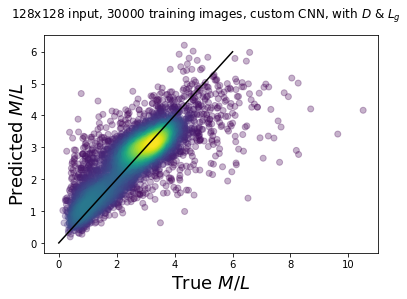

In [117]:
from wdplot.prep import estimate_density

xc, yc, c = estimate_density(d_data['test']['y'], d_data['test']['y_pred'])
plt.scatter(xc, yc, c=c, alpha=0.3)
# line = [-0.75, 1.]
line = [0, 6]
plt.plot(line, line, 'k-')
fs = 18
plt.xlabel(r'True $M/L$', fontsize=fs)
plt.ylabel(r'Predicted $M/L$', fontsize=fs)
plt.suptitle('128x128 input, 30000 training images, custom CNN, with $D$ & $L_g$')
plt.savefig('plots/truevspred/128pix_custom_addinput.png')

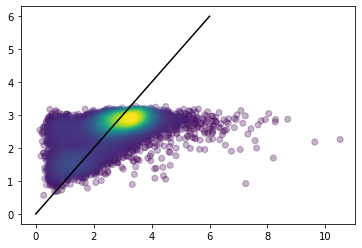

In [30]:
ylin_pred = np.power(10, y_pred)
ylin_test = np.power(10, y_test.values)
xc, yc, c = estimate_density(ylin_test, ylin_pred)
plt.scatter(xc, yc, c=c, alpha=0.3)
line = [0., 6.]
plt.plot(line, line, 'k-')

# Visualizing for test

Ensure things work as expected using plots.

## Data augmentation

In [22]:
n_plot = 5
n_draw = 5

augmented_train_batches = (
    train_dataset
        .take(n_plot)
        .cache()
#         .shuffle(n_train // 4)
        .map(augment)
#         .batch(batch_size)
)

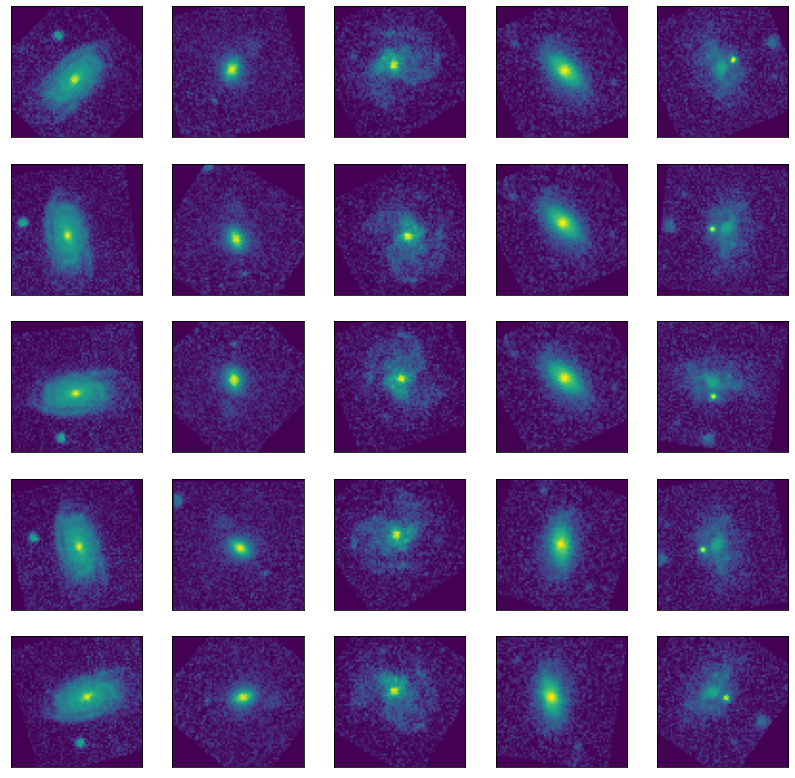

In [23]:
f, axarr = plt.subplots(n_plot, n_draw, figsize=(14, 14))
for i in range(n_draw):
    for j, (image, label) in enumerate(augmented_train_batches):
        image = image.numpy().squeeze()
        axarr[i, j].imshow(image)
        axarr[i, j].get_xaxis().set_visible(False)
        axarr[i, j].get_yaxis().set_visible(False)